# Parametric VaR Calculation for a Stock Portfolio
**Author:** Winifred Mei  
**Date:** August 21, 2025  

In this notebook, we calculate the **Value at Risk (VaR)** for a portfolio using the **parametric method**.  
We will analyze historical stock data, compute portfolio statistics, and estimate VaR at multiple confidence levels.


## Define Analysis Timeframe and Portfolio Stocks

We start by specifying the time range for our analysis and listing the tickers in our portfolio.


In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

# Time horizon for historical data
years_back = 12
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365*years_back)

# Portfolio tickers (diversified)
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']


## Download Daily Prices and Compute Daily Log Returns

Fetch historical adjusted close prices and calculate **daily logarithmic returns** for each stock.


In [2]:
price_data = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    price_data[ticker] = data['Close']

# Calculate daily log returns
log_returns = np.log(price_data / price_data.shift(1)).dropna()


/var/folders/fb/yy69flkj2yv4cyv2j0q3jyzw0000gn/T/ipykernel_4265/1462447819.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/fb/yy69flkj2yv4cyv2j0q3jyzw0000gn/T/ipykernel_4265/1462447819.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/fb/yy69flkj2yv4cyv2j0q3jyzw0000gn/T/ipykernel_4265/1462447819.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/fb/yy69flkj2yv4cyv2j0q3jyzw0000gn/T/ipykernel_4265/1462447819.py:4: FutureWarning: YF.download() has changed argument au

## Build Equally Weighted Portfolio and Compute Portfolio Returns

We create a portfolio with **equal weights** and calculate its daily returns.


In [4]:
portfolio_value = 600_000
weights = np.array([1/len(tickers)] * len(tickers))

portfolio_returns = (log_returns * weights).sum(axis=1)

## Compute Rolling X-Day Portfolio Returns

We calculate rolling cumulative returns over a **5-day window** to estimate short-term risk.

In [5]:
rolling_days = 5
rolling_returns = portfolio_returns.rolling(window=rolling_days).sum()


## Calculate Covariance Matrix and Portfolio Volatility

We calculate the annualized covariance matrix and use it to compute the **portfolio standard deviation**.


In [6]:
cov_matrix_annual = log_returns.cov() * 252
portfolio_std = np.sqrt(weights.T @ cov_matrix_annual @ weights)


## Compute Parametric VaR at Multiple Confidence Levels

We calculate the **parametric VaR** for confidence levels of 90%, 95%, and 99%.


In [7]:
confidence_levels = [0.90, 0.95, 0.99]
VaR_values = []

for cl in confidence_levels:
    VaR = portfolio_value * (norm.ppf(1 - cl) * portfolio_std * np.sqrt(rolling_days / 252) - portfolio_returns.mean() * rolling_days)
    VaR_values.append(VaR)


## Display VaR Results

Print the estimated VaR for each confidence level.


In [8]:
print(f'{"Confidence Level":<20} {"Parametric VaR":<20}')
print('-'*40)

for cl, var in zip(confidence_levels, VaR_values):
    print(f'{int(cl*100):>6}%: {"":<8} ${var:>10,.2f}')


Confidence Level     Parametric VaR      
----------------------------------------
    90%:          $-31,837.87
    95%:          $-40,079.31
    99%:          $-55,538.87


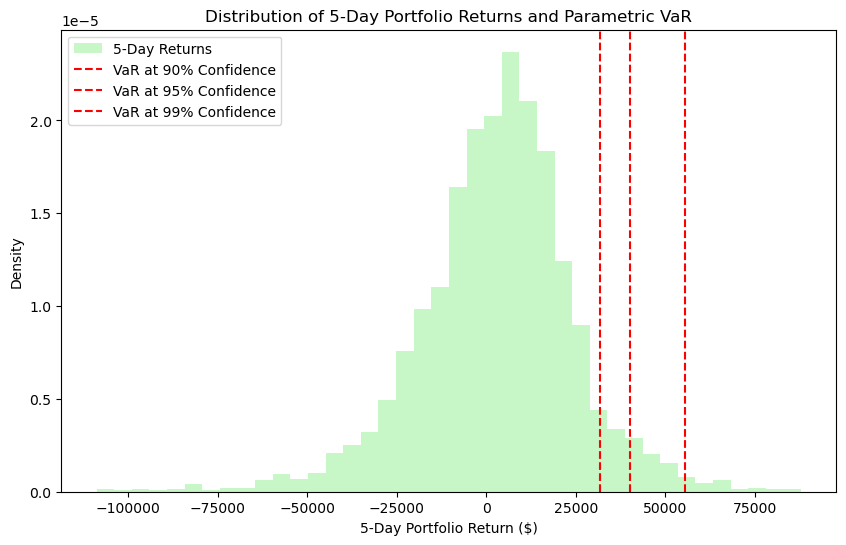

In [9]:
# Convert to dollar values
rolling_returns_dollar = rolling_returns * portfolio_value

plt.figure(figsize=(10,6))
plt.hist(rolling_returns_dollar, bins=40, density=True, alpha=0.5, color='lightgreen', label=f'{rolling_days}-Day Returns')

# Plot vertical lines for VaR at each confidence level
for cl, var in zip(confidence_levels, VaR_values):
    plt.axvline(x=-var, linestyle='--', color='red', label=f'VaR at {int(cl*100)}% Confidence')

plt.xlabel(f'{rolling_days}-Day Portfolio Return ($)')
plt.ylabel('Density')
plt.title(f'Distribution of {rolling_days}-Day Portfolio Returns and Parametric VaR')
plt.legend()
plt.show()
